In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
%matplotlib inline

from aSPEM import Analysis
e = Analysis()#observer=observer, mode=mode)

# P_reel

In [2]:
exts = ['.png', '.svg', '.pdf']

/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:329: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:329: RuntimeWarning: invalid value encountered in true_divide


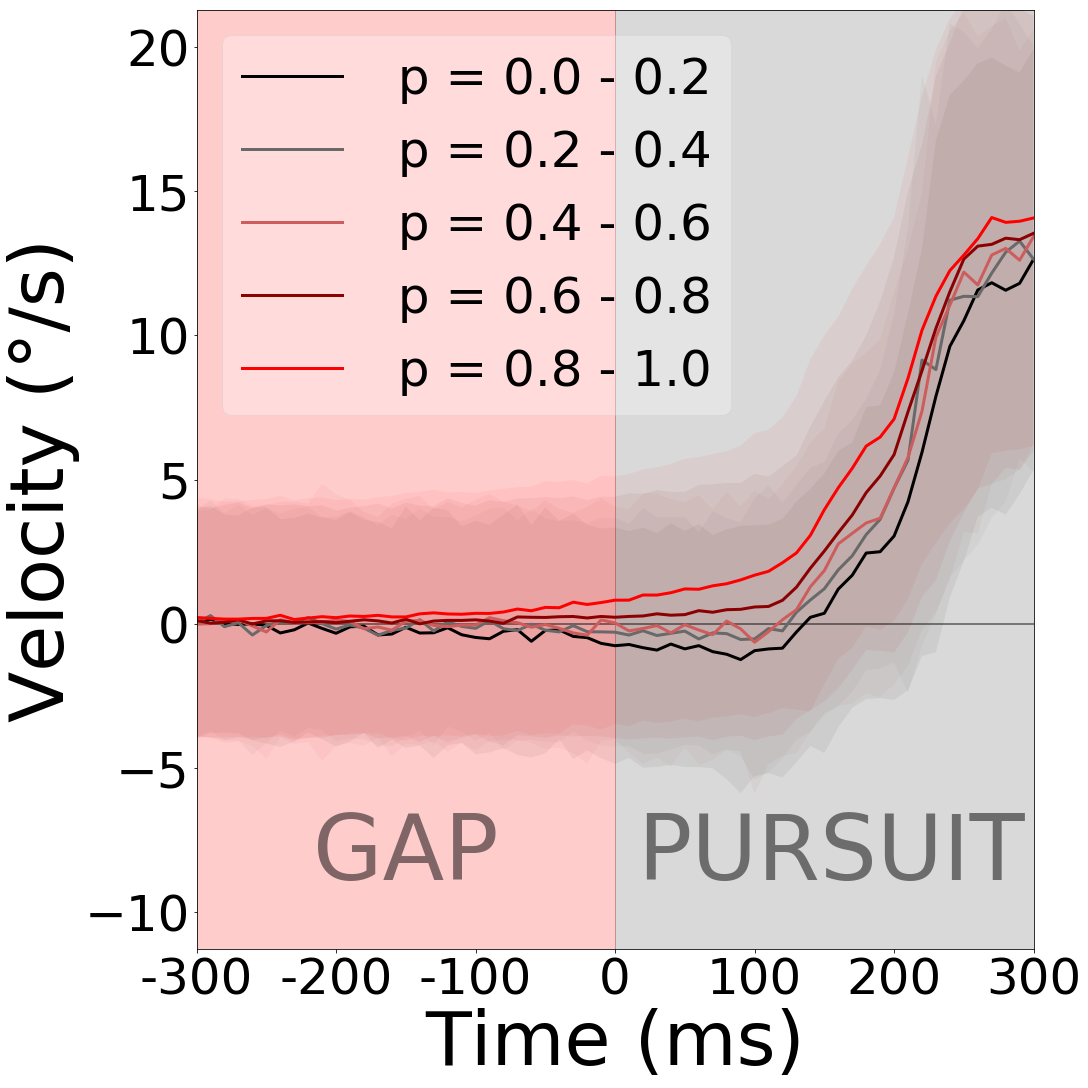

In [3]:
fig_width = 15
t_titre = 0
t_label = 30*3

delta = 0.2
color = ['black','dimgrey','indianred','darkred','red']
#color = ['black','grey','darkgrey','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
#color = []
#for n in range(int(1/delta)) :
#    color.append((0+delta*n, 0, 0, 0.5))

fig, axs = plt.subplots(1, 1, figsize=(1*fig_width, 1*fig_width), constrained_layout=True)#/(1.6180*1)))
axs = e.Plot_Average_Trace_P_real(delta, color, mean=True, ax=axs, show='r',
                                  title='', fig_width=fig_width, t_titre=t_titre, t_label=t_label)
plt.show()

for ext in exts:
    fig.savefig('ms/figures/1_B_Trace_moyenne' + ext, dpi=400)
fig.savefig('figures/Trace_moyenne.pdf', dpi=400)